In [394]:
# We're going to start off in a jupyter notebook and slowly move this into a widget... for visualization with tests and stuff
#%matplotlib notebook
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from functools import reduce
from operator import concat
import glob

import pandas as pd

import seaborn as sns
sns.set_theme()

In [395]:
# the goal of this is going to be showing someone about this data... and building data loaders

participant = 3
walk = 18
#file = f'/Users/kbonnen/Desktop/BerkeleyDataFailedSharepointDownload/berkeley_pupilShadowMesh/s{str(participant)}_{str(walk)}_pupilShadowMesh.mat'
data = sio.loadmat('/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh/s3_5_pupilShadowMesh.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 'markerNames', 'shadow', 'step_plantfoot_xyz', 'y_flip', 'z_flip'])

In [396]:
environment_mesh = data['allPoints'] 
markers = data['markerNames'];
skeleton = data['shadow'] # num of frames x num of pose landmarks x XYZ coordinates
hips = np.squeeze(skeleton[:,1,:])
footholds = data['step_plantfoot_xyz']
gazeGround = data['gazeXYZ']

# make a list of the foothold # at each gaze sample
frame_edges = np.append(np.append(1,footholds[:,0]),gazeGround.shape[0]+1)
frames_per_foothold = np.diff(frame_edges)
current_foothold = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))

walk = pd.DataFrame({'ground_x':gazeGround[:,0],'ground_z':gazeGround[:,2], 
                   'foothold':current_foothold, 'hips_x':hips[:,0], 'hips_z':hips[:,2]})

footholds_df= pd.DataFrame({'foothold_x':footholds[:,2],'foothold_z':footholds[:,4],'leg':footholds[:,1]})

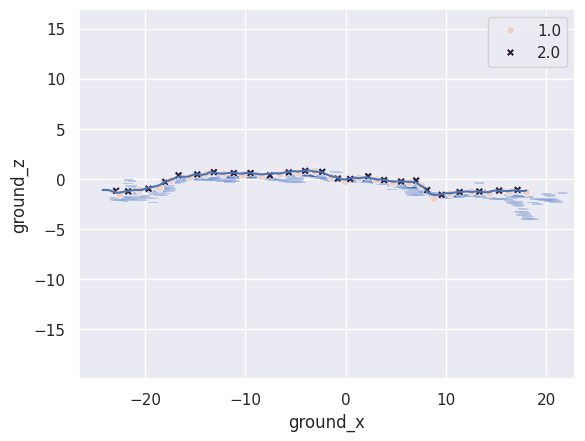

In [397]:
sns.kdeplot(data=walk, x="ground_x", y="ground_z",fill=True, bw_adjust=0.1)
sns.scatterplot(data=footholds_df,x='foothold_x',y='foothold_z',hue='leg',style='leg')
sns.lineplot(data=walk,x="hips_x",y="hips_z")
plt.axis('equal')
plt.show()



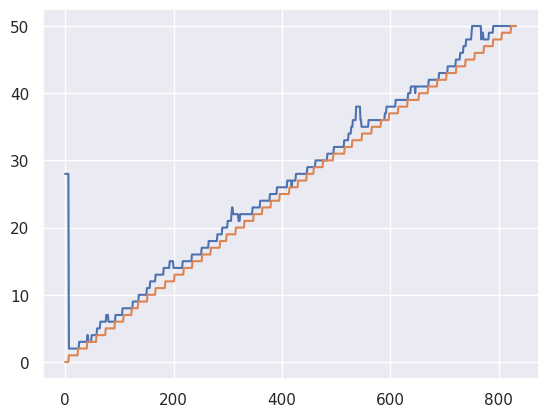

<Axes: >

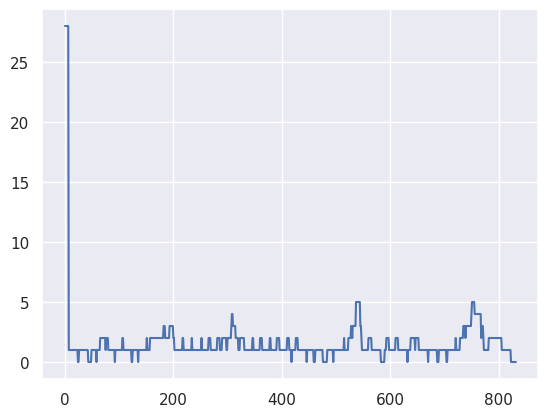

In [398]:
from scipy.spatial.distance import cdist
distances = cdist(gazeGround,footholds[:,2:])

closest_foothold = np.argmin(distances,axis=1)+1

sns.lineplot(closest_foothold)
sns.lineplot(current_foothold)
plt.show()

sns.lineplot(closest_foothold-current_foothold)

(array([  6., 218.,  23.,   0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5]),
 <BarContainer object of 4 artists>)

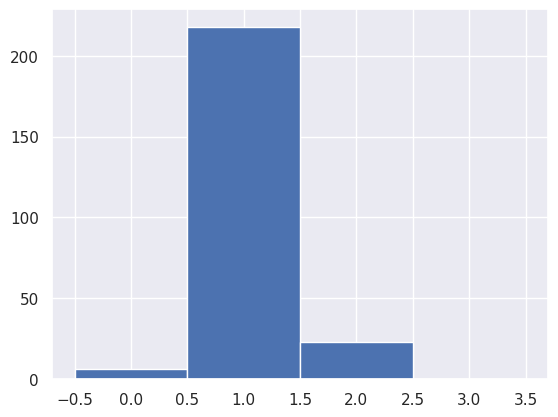

In [399]:
dmin= np.min(distances, axis = 1)
rel_foothold_fixation = np.where(dmin > 0.4, np.nan, closest_foothold-current_foothold)
plt.hist(rel_foothold_fixation, bins= np.arange(np.nanmin(rel_foothold_fixation)- 0.5,
         np.nanmax(rel_foothold_fixation) + 0.5, 1))

In [400]:
def find_walks_with_type(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    walkNum = walks
    return walkNum
    
    


In [401]:
def find_walks_with_type(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    walkNum = walks
    

    rel_foothold_fixation = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')    
        marker,skeleton,footholds,gazeGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        hips = np.squeeze(skeleton[:,1,:])

        frame_edges = np.append(np.append(1,footholds[:,0]),gazeGround.shape[0]+1)
        frames_per_foothold = np.diff(frame_edges)
        current_foothold = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))

        distances = cdist(gazeGround,footholds[:,2:])
        closest_foothold = np.argmin(distances,axis=1)+1
        distances_min= np.min(distances, axis = 1)
        
        rff = np.where(distances_min > 0.4, np.nan, closest_foothold-current_foothold)
        rel_foothold_fixation.append(rff)
    rel_foothold_fixation = np.hstack(rel_foothold_fixation)
    
    plt.hist(rel_foothold_fixation, bins= np.arange(np.nanmin(rel_foothold_fixation)- 0.5,
                np.nanmax(rel_foothold_fixation) + 0.5, 1))
    plt.show

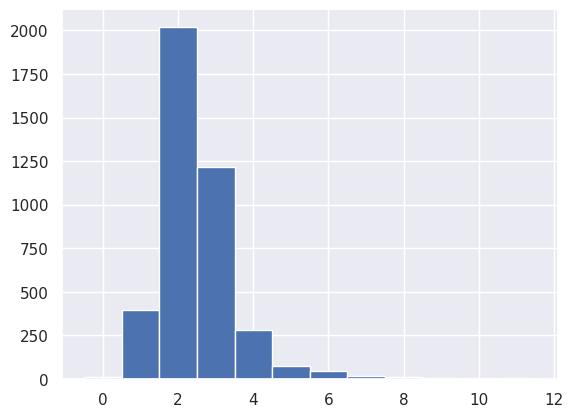

In [402]:
find_walks_with_type(3,'rock')

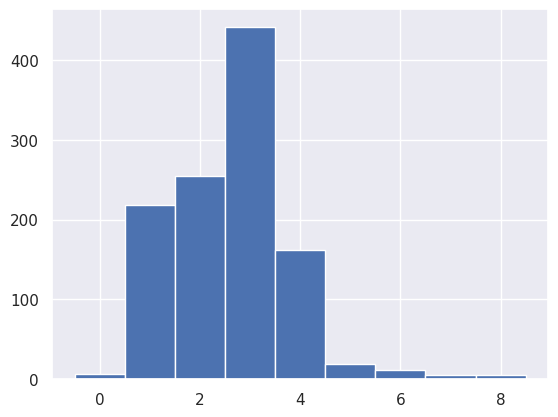

In [403]:
find_walks_with_type(3,'medium')

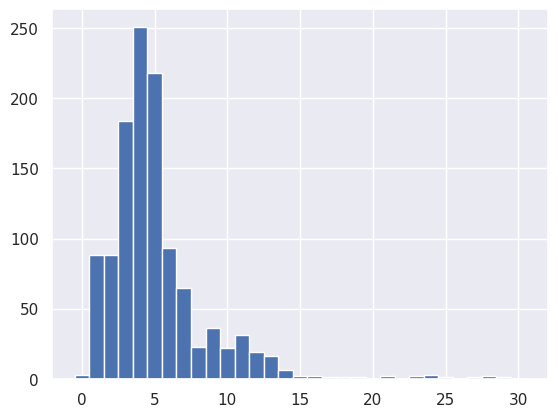

In [404]:
find_walks_with_type(3,'flat')

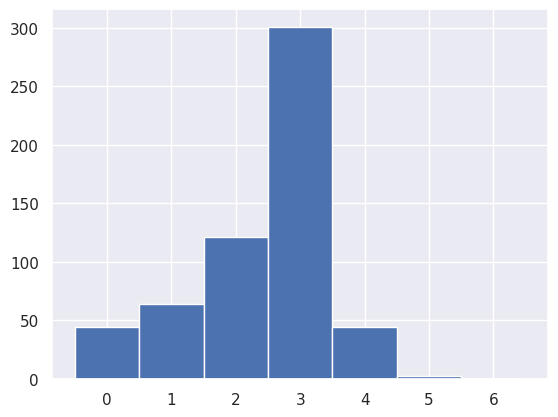

In [405]:
find_walks_with_type(3,'narrow')